In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import functools


In [8]:
trainpath = "./data/train"
testpath = "./data/test"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]
imgs_test = [os.path.join(testpath,i) for i in os.listdir(testpath)]

df = pd.DataFrame({"image":imgs,"mask":masks})
df_train, df_val = train_test_split(df,test_size = 0.15)
df_test =  pd.DataFrame({"image":imgs_test})
# df_test


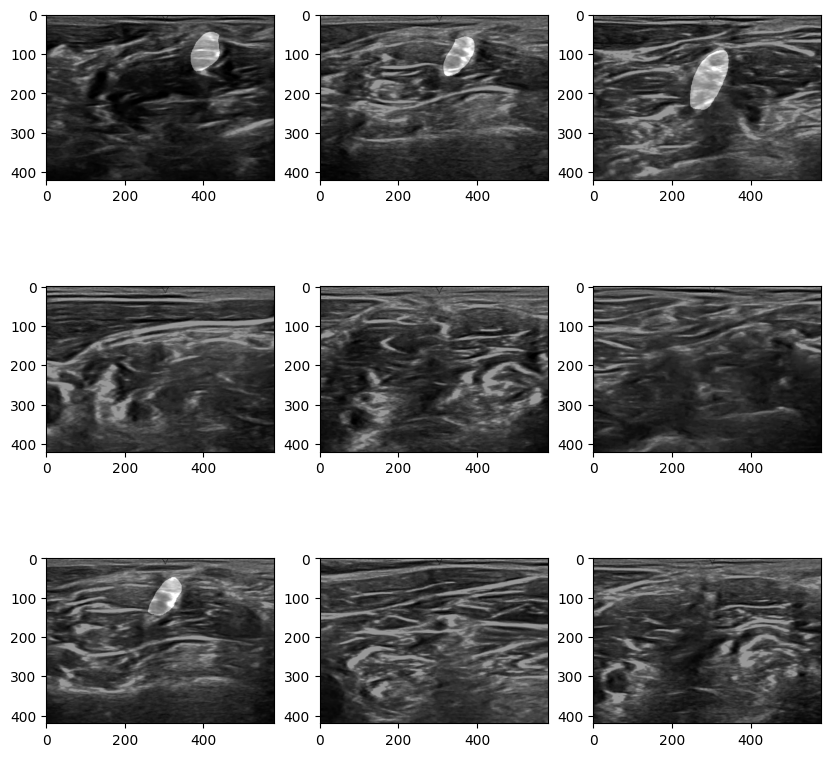

In [9]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df))
    fig.add_subplot(rows,cols,i)
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
plt.show()

In [10]:
train_data = [(np.array(Image.open(img)) / 255.0).astype(np.float32) for img in df_train.iloc[:, 0]]
train_data_masks = [(np.array(Image.open(mask)) / 255.0).astype(np.float32) for mask in df_train.iloc[:, 1]]
val_data = [(np.array(Image.open(img)) / 255.0).astype(np.float32) for img in df_val.iloc[:, 0]]
val_data_masks = [(np.array(Image.open(mask)) / 255.0).astype(np.float32) for mask in df_val.iloc[:, 1]]
test_data = [np.array(Image.open(df_test.iloc[i,0])) for i in range(len(df_test))]

In [11]:
labels_train=[]
labels_val=[]
for mask in train_data_masks:
    if np.any(mask):
        labels_train.append(1)  # 1: nerve present
    else:
        labels_train.append(0)  # 0: nerve not present

for mask in val_data_masks:
    if np.any(mask):
        labels_val.append(1)
    else:
        labels_val.append(0)

In [12]:
def process_res(img_lst, labels):
    processed_data = []
    for img, label in zip(img_lst, labels):
        img = np.array(img)  # Convert single image to numpy array
        if img.ndim == 2:  # Ensure image has 3 dimensions
            img = img[..., np.newaxis]
            img = np.repeat(img, 3, axis=-1)
        elif img.shape[2] == 1:
            img = np.repeat(img, 3, axis=-1)

        if label is not None:
            label = tf.convert_to_tensor(label)
            label = tf.one_hot(label, depth=2)

        data = tf.image.resize(tf.convert_to_tensor(img), [224,224])
        processed_data.append((data, label))

    processed_images, processed_labels = zip(*processed_data)
    processed_images = tf.stack(processed_images)
    if labels[0] is not None:
        processed_labels = tf.stack(processed_labels)
    else:
        processed_labels = None
    return processed_images, processed_labels

train_ds = process_res(train_data,labels_train)
val_ds = process_res(val_data,labels_val)
test_ds = process_res(test_data,[None]*len(test_data))
# print(train_ds[1])


### Transfer learning using ResNet50 on imagnet for classification

In [19]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)


In [20]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [21]:
for layer in model.layers[:143]:
   layer.trainable = False
for layer in model.layers[143:]:
   layer.trainable = True

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=2, verbose=1)

e_stop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=3, 
          verbose=0,  restore_best_weights=True)

callbacks = [reduce_lr, e_stop]
# print(val_ds[1].shape)

In [25]:
optim =  tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics='accuracy')
# model.summary()

history = model.fit(x=train_ds[0],y=train_ds[1],
           validation_data = val_ds,
           batch_size=32,
           shuffle =True,
           callbacks = callbacks,
           epochs=25)

Epoch 1/25
150/150 [==============================] - 529s 4s/step - loss: 1.7587 - accuracy: 0.7881 - val_loss: 1.8045 - val_accuracy: 0.7470 - lr: 1.0000e-05
Epoch 2/25
150/150 [==============================] - 263s 2s/step - loss: 1.6799 - accuracy: 0.8083 - val_loss: 1.7896 - val_accuracy: 0.7376 - lr: 1.0000e-05
Epoch 3/25
150/150 [==============================] - 342s 2s/step - loss: 1.6178 - accuracy: 0.8267 - val_loss: 1.7196 - val_accuracy: 0.7553 - lr: 1.0000e-05
Epoch 4/25
150/150 [==============================] - 243s 2s/step - loss: 1.5609 - accuracy: 0.8311 - val_loss: 1.6719 - val_accuracy: 0.7754 - lr: 1.0000e-05
Epoch 5/25
150/150 [==============================] - 623s 4s/step - loss: 1.5069 - accuracy: 0.8380 - val_loss: 1.6450 - val_accuracy: 0.7730 - lr: 1.0000e-05
Epoch 6/25
150/150 [==============================] - 417s 3s/step - loss: 1.4540 - accuracy: 0.8515 - val_loss: 1.6285 - val_accuracy: 0.7730 - lr: 1.0000e-05
Epoch 7/25
150/150 [====================

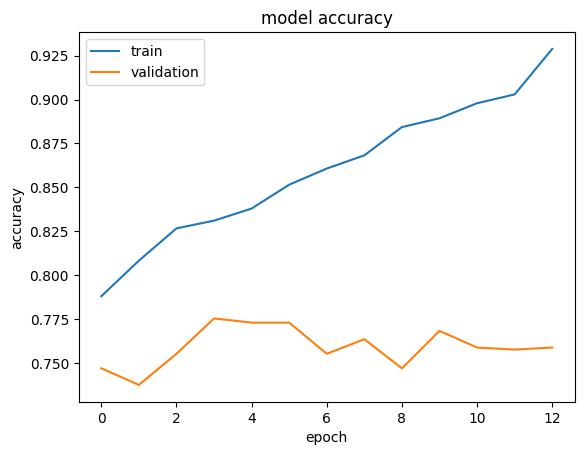

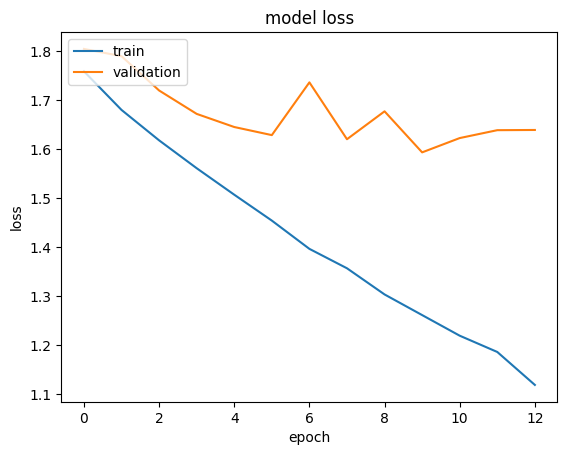

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
results = model.evaluate(val_ds[0], val_ds[1], batch_size=64)
predictions = model.predict(val_ds[0], verbose=1)
pred_bool = tf.one_hot(np.argmax(predictions, axis=1),depth=2)
test_pred = model.predict(test_ds[0], verbose=1)
print(classification_report(val_ds[1], pred_bool))

173/173 [==============================] - 156s 902ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       506
           1       0.72      0.70      0.71       340

   micro avg       0.77      0.77      0.77       846
   macro avg       0.76      0.76      0.76       846
weighted avg       0.77      0.77      0.77       846
 samples avg       0.77      0.77      0.77       846



### Transfer learning from VGG in Unet model for segmentation

In [28]:
from tensorflow.keras.layers import BatchNormalization,Conv2DTranspose,Conv2D,concatenate
from tensorflow.keras.applications.vgg16 import VGG16

In [52]:
def Unet_model(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    # print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    up1 = BatchNormalization()(up1)
    # print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up2 = BatchNormalization()(up2)
    # print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)


    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up3 = BatchNormalization()(up3)
    # print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up4 = BatchNormalization()(up4)
    # print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    # print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_


In [53]:
U_model = Unet_model((224,224,3)) 

In [54]:
def process_mask(mask):
  mask=np.array(mask)[:,:,:,np.newaxis]
  masks = tf.image.resize(tf.convert_to_tensor(mask), [224,224])
  return masks

train_masks = process_mask(train_data_masks)
val_masks = process_mask(val_data_masks)
# plt.imshow(train_masks[564],cmap='gray')
# plt.show()
# print(train_masks[5][100])
# print(val_masks.shape)
# print(len(train_data_masks))

In [55]:
#Get images with with nerve only (positive classification)
positive_train=(np.where(np.array(labels_train)==1)[0]).tolist()
positive_val=(np.where(np.array(labels_val)==1)[0]).tolist()
test_max=np.argmax(test_pred,axis=1)
positive_test=(np.where(np.array(test_max)==1)[0]).tolist()

In [56]:
print(len(positive_train))

1983


In [57]:
train_data_positive=[]
train_masks_positive=[]
val_data_positive=[]
val_masks_positive=[]

for train_idx in positive_train:
    train_data_positive.append(train_ds[0][train_idx])
    train_masks_positive.append(train_masks[train_idx])

for mask_idx in positive_val:
    val_data_positive.append(val_ds[0][mask_idx])
    val_masks_positive.append(val_masks[mask_idx])


In [58]:
data = tf.convert_to_tensor(train_data_positive)
mask = tf.convert_to_tensor(train_masks_positive)
val = tf.convert_to_tensor(val_data_positive)
vmask = tf.convert_to_tensor(val_masks_positive)

In [59]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [60]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
U_model.compile(optimizer="adam", 
                loss=dice_loss,
                metrics=[dice_coefficient,
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()]
                       )

u_history = U_model.fit(x=data,y=mask,
           validation_data = (val,vmask),
           batch_size=32,
           callbacks = callbacks,
           shuffle = True,
           epochs=10,
           verbose=1)

Epoch 1/10
62/62 [==============================] - 1357s 22s/step - loss: 0.6264 - dice_coefficient: 0.3737 - binary_accuracy: 0.9033 - precision_5: 0.2262 - recall_5: 0.8966 - val_loss: 0.7492 - val_dice_coefficient: 0.2506 - val_binary_accuracy: 0.8432 - val_precision_5: 0.1596 - val_recall_5: 0.9623 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - 983s 16s/step - loss: 0.3360 - dice_coefficient: 0.6640 - binary_accuracy: 0.9803 - precision_5: 0.6483 - recall_5: 0.8323 - val_loss: 0.4796 - val_dice_coefficient: 0.5207 - val_binary_accuracy: 0.9516 - val_precision_5: 0.3794 - val_recall_5: 0.8663 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - 992s 16s/step - loss: 0.2431 - dice_coefficient: 0.7569 - binary_accuracy: 0.9855 - precision_5: 0.7594 - recall_5: 0.7994 - val_loss: 0.3053 - val_dice_coefficient: 0.6951 - val_binary_accuracy: 0.9771 - val_precision_5: 0.6006 - val_recall_5: 0.8429 - lr: 0.0010
Epoch 4/10
62/62 [==============================

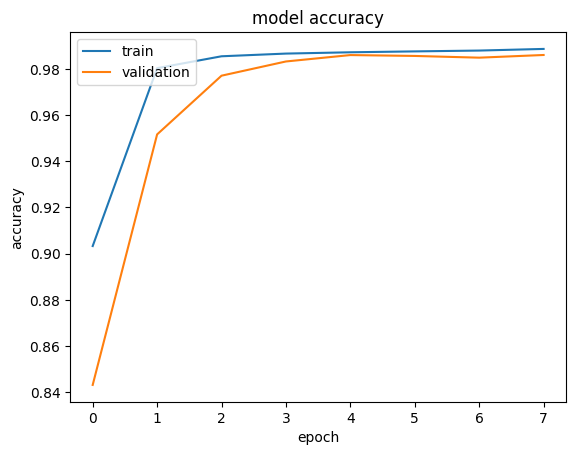

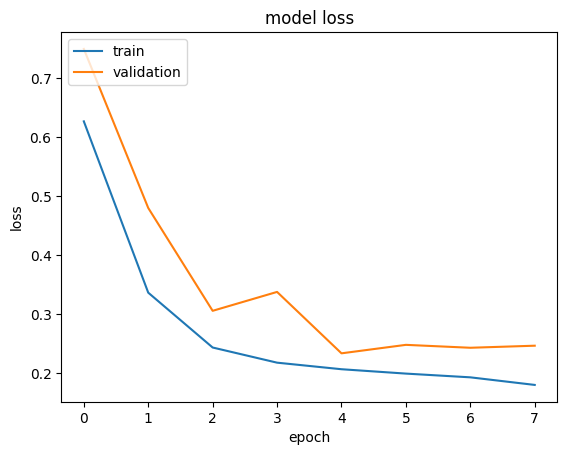

In [65]:
# summarize history for accuracy
plt.plot(u_history.history['binary_accuracy'])
plt.plot(u_history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(u_history.history['loss'])
plt.plot(u_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
def visualize_predictions(model, test_images, test_masks, num_samples=5):
    
    indices = np.random.choice(len(test_images), num_samples, replace=False)

    plt.figure(figsize=(10, 5 * num_samples)) 

    for i, idx in enumerate(indices):
        img = test_images[idx]
        true_mask = test_masks[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]  

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray') 
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 190ms/step


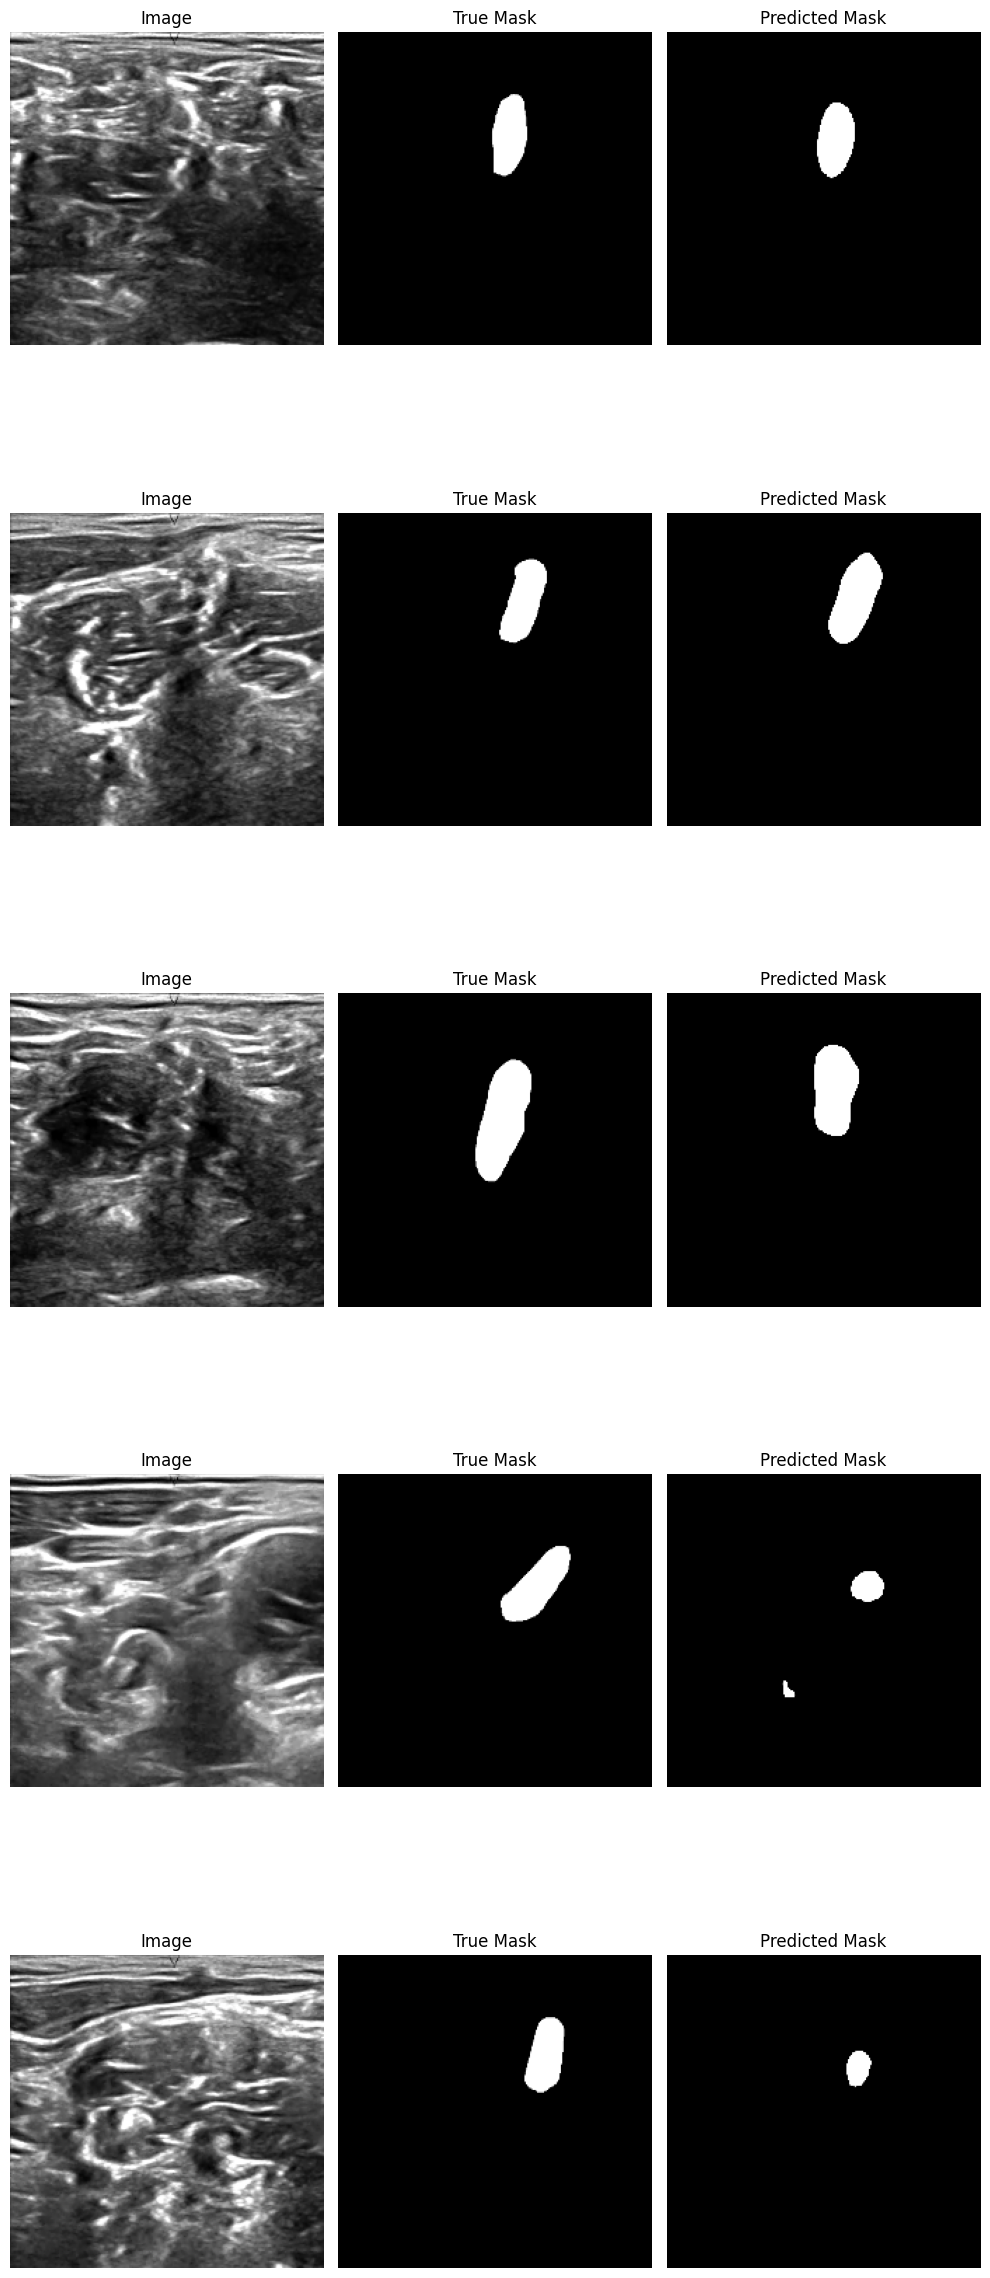

In [70]:
visualize_predictions(U_model, val_data_positive, val_masks_positive, num_samples=5)